# SISTER CWL submission
***

In [1]:
import json
import os
import xml.etree.ElementTree as ET
import pandas as pd
import requests
import IPython
from itertools import groupby
import datetime as dt 
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

/var/folders/6t/5__g6bsd0835cvl9my049cf00000gq/T/ipykernel_6499/3569537596.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_quicklook(job_id):
    result = maap.getJobResult(job_id)
    granule = result.outputs[0]
    return f'{granule}/{os.path.basename(granule)}.png'

### Load production list with scene URLs


In [3]:
scene_df = pd.read_csv('./sister_production_5_list.csv', encoding='utf-8-sig')
# Strip unicode character
scene_df.l1_granule = scene_df.l1_granule.map(lambda x: x.replace('\ufeff',''))
scene_df.tail()

,Instrument,Domain,Area,Flight Line,Platform,l1_granule,Valid URL,Valid URL.1,Priority
0,AVIRIS Classic,Aquatic,"Kaneohe Bay, Oahu",f180126t01p00r08,1,https://popo.jpl.nasa.gov/avcl/y18_data/f18012...,True,True,HIGH
1,AVIRIS Classic,Snow/Ice,"Grand Mesa,CO",f110513t01p00r03,1,https://popo.jpl.nasa.gov/avcl/y11_data/f11051...,True,True,LOW
2,AVIRIS Classic,Terrestrial,"Sierras, CA",f130612t01p00r10,1,https://popo.jpl.nasa.gov/avcl/y13_data/f13061...,True,True,LOW


### Workflow configuration generator

The configuration generator function takes as input the URL to the L1 granule and a composite release identifier (crid) and returns a scene identifier along with a workflow configuration for the scene.

In [10]:
def gen_config(l1_granule,crid):
    
    '''Generate CWL workflow configuration
    
    Arguments
    
    l1_granule (str): Input scene URL 
    
    Returns:
    
    identifier(str): Unique scene identification code
    
            SISTER_SENSOR_YYYMMDDTHHMMSS
        ex:
    
            SISTER_PRISMA_20200918T100312
            
    input_config (list): List of workflow PGE configurations

    '''
    landsat = 'None'   
    preprocess_queue = "sister-job_worker-32gb"
    segmentation_size = 50
    
    base_name = os.path.basename(l1_granule)
    
    if base_name.startswith('DESIS'):
        sensor = 'DESIS'
        datetime = base_name[31:46]
        
    elif base_name.startswith('PRS'):
        sensor = 'PRISMA'
        datetime = base_name[16:24] + 'T' + base_name[24:30]
        landsat='https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/landsat_reference/PRS_%s_landsat.tar.gz' % base_name[16:50]
        
    elif base_name.startswith('ang'):
        sensor = 'AVNG'
        datetime = base_name[3:18].upper()
        
        if datetime in ['20210429T185512', '20210429T185927']:
            segmentation_size = 25

    elif base_name.startswith('f'):
        sensor = 'AVCL'
        ''' AVIRIS classic filenames do not contain acquisition times,to be consistent with other
            sensors and to ensure identifier codes are unique a time string is created using other
            numbers in the filename            
        '''     
                
        datetime = "20%sT%s%s%s" % (base_name[1:7],
                                    base_name[8:10],
                                    base_name[11:13],
                                    base_name[14:16])
        
        preprocess_queue = "sister-job_worker-32gb"
        
        #Run large Sierra scenes with larger segmentation size
        if ('f130612' in base_name) or ('f210326' in base_name):
            segmentation_size = 100

    elif base_name.startswith("EMIT"):
        sensor = 'EMIT'
        datetime = base_name.split('_')[4]
        preprocess_queue = "sister-job_worker-32gb"

        
    else:
        raise ValueError('Unrecognized L1 datafile')
                
    #Check if input file exists
    inputs_exist = requests.head(l1_granule).status_code != 500
    # Check if landsat reference file exists
    if sensor == 'PRISMA':
        inputs_exist &= requests.head(landsat).status_code != 500
        
    if not inputs_exist:
        print('Input file not found.')
        return False,False
        
    input_config =  [
    {
      "step_key": "l1b_preprocess",
      "algorithm_id": "ogc-sister-preprocess",
      "version":  "3.0.0",
      "queue": preprocess_queue,
      "params": {
        "raw_dataset": l1_granule,
        "crid" : crid,
        "experimental": "True",
        "identifier": f"EXPERIMENTAL-SISTER_{sensor}_L1B_RDN_{datetime}_{crid}",
        "username":"production5"
      }
    },
    {
      "step_key": "l2a_reflectance",
      "algorithm_id": "ogc-sister-isofit",
      "queue": "sister-job_worker-32gb",
      "version": "3.0.0",
      "input_filter": {
        "radiance_dataset":  f"*RDN*{crid}",
        "location_dataset": "*RDN*LOC",
        "observation_dataset": "*RDN*OBS",          
      },
      "params": {
        "radiance_dataset": None,
        "location_dataset": None,
        "observation_dataset": None,
        "n_cores": 32,
        "segmentation_size": segmentation_size,
        "crid": crid,
          "experimental": "True",
        "identifier": f"EXPERIMENTAL-SISTER_{sensor}_L2A_RFL_{datetime}_{crid}",
        "username":"production5"
      }
    },
    {
      "step_key": "l2a_resample",
      "algorithm_id": "ogc-sister-resample",
      "version":"3.0.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "reflectance_dataset": f"*_RFL_*{crid}",
        "uncertainty_dataset": "*_RFL*UNC"

      },
      "params": {
        "reflectance_dataset": None,
        "uncertainty_dataset":None,
        "crid" : crid,
          "experimental": "True",
        "identifier": f"EXPERIMENTAL-SISTER_{sensor}_L2A_RSRFL_{datetime}_{crid}",
        "username":"production5"

      }
    },
    {
      "step_key": "l2a_reflectance_correction",
      "algorithm_id": "ogc-sister-reflect_correct",
      "version": "3.0.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "observation_dataset": "*RDN*OBS",
        "reflectance_dataset": f"*RSRFL*{crid}"
      },
      "params": {
        "observation_dataset": None,
        "reflectance_dataset": None,
        "crid" : crid,
          "experimental": "True",
        "identifier": f"EXPERIMENTAL-SISTER_{sensor}_L2A_CORFL_{datetime}_{crid}",
        "username":"production5"

      }
    },
    {
      "step_key": "l2b_factional_cover",
      "algorithm_id": "ogc-sister-fractional-cover",
      "version": "2.0.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "reflectance_dataset": "*CORFL*"
      },
      "params": {
        "reflectance_dataset": None,
        "n_cores": 10,
        "refl_scale": 1,
        "crid" : crid,
          "experimental": "True",
        "identifier": f"EXPERIMENTAL-SISTER_{sensor}_L2B_FRCOV_{datetime}_{crid}",
        "username":"production5"
      }
    },

    {
      "step_key": "l2b_vegbiochem",
      "algorithm_id": "ogc-sister-trait_estimate",
      "version": "2.0.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "reflectance_dataset": "*CORFL*",
        "frcov_dataset": "*L2B_FRCOV*"
      },
      "params": {
        "reflectance_dataset": None,
        "frcov_dataset": None,
        "veg_cover": 0.5,
        "crid" : crid,
          "experimental": "True",
        "identifier": f"EXPERIMENTAL-SISTER_{sensor}_L2B_VEGBIOCHEM_{datetime}_{crid}",
        "username":"production5"
      }
    },
        
     {
      "step_key": "l2b_grainsize",
      "algorithm_id": "ogc-sister-grainsize",
      "version": "2.0.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "reflectance_dataset": "*CORFL*",
        "frcov_dataset": "*L2B_FRCOV*"
      },
      "params": {
        "reflectance_dataset": None,
        "frcov_dataset": None,
        "snow_cover": 0.9,
        "crid" : crid,
          "experimental": "True",
        "identifier": f"EXPERIMENTAL-SISTER_{sensor}_L2B_GRAINSIZE_{datetime}_{crid}",
        "username":"production5"
      }
    },   
    
    {
      "step_key": "l2b_aquatic_pigments",
      "algorithm_id": "ogc-sister-aquatic-pigments-pge",
      "version": "2.0.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "corrected_reflectance_dataset": "*CORFL*",
        "fractional_cover_dataset": "*L2B_FRCOV*"
      },
      "params": {
        "corrected_reflectance_dataset": None,
        "fractional_cover_dataset": None,
        "crid" : crid,
          "experimental": "True",
        "identifier": f"EXPERIMENTAL-SISTER_{sensor}_L2B_AQUAPIG_{datetime}_{crid}",
        "username":"production5"
      }
    },
      {
        "step_key": "sister_router",
        "snow_cover": 0.9,
        "veg_cover": 0.5,
        "min_pixels": 100,
        "soil_cover": 0.5,
        "water_cover": 0.9
      }
          
  ]

    return sensor,datetime,json.dumps(input_config,indent=4)
    

### Generate single CWL workflow configuration

In [12]:
crid = "004"
sensor,datetime,input_config = gen_config('https://popo.jpl.nasa.gov/avcl/y11_data/f110513t01p00r03.tar.gz',
                                    crid)
print(input_config)
print(sensor,datetime)

[
    {
        "step_key": "l1b_preprocess",
        "algorithm_id": "ogc-sister-preprocess",
        "version": "3.0.0",
        "queue": "sister-job_worker-32gb",
        "params": {
            "raw_dataset": "https://popo.jpl.nasa.gov/avcl/y11_data/f110513t01p00r03.tar.gz",
            "crid": "004",
            "experimental": "True",
            "identifier": "EXPERIMENTAL-SISTER_AVCL_L1B_RDN_20110513T010003_004",
            "username": "production5"
        }
    },
    {
        "step_key": "l2a_reflectance",
        "algorithm_id": "ogc-sister-isofit",
        "queue": "sister-job_worker-32gb",
        "version": "3.0.0",
        "input_filter": {
            "radiance_dataset": "*RDN*004",
            "location_dataset": "*RDN*LOC",
            "observation_dataset": "*RDN*OBS"
        },
        "params": {
            "radiance_dataset": null,
            "location_dataset": null,
            "observation_dataset": null,
            "n_cores": 32,
            "segmentatio

### Submit single CWL workflow job

In [23]:
identifier = f"OGC-EXPERIMENTAL-SISTER_{sensor}_CWL_{datetime}_{crid}"

job_response = maap.submitJob(
       algo_id="run_sister_workflow",
       version="dev",
       queue="sister-workflow",
       identifier= identifier,
       username="anonymous",
       workflow_config=input_config,
       precondition_file="sister_router.py")

print("Submitted %s CWL worflow job" %  identifier)
print("    Submission status: %s" % job_response.status )
print("    Submission status: %s" % job_response.id )


Submitted OGC-EXPERIMENTAL-SISTER_AVCL_CWL_20110513T010003_902 CWL worflow job
    Submission status: success
    Submission status: 368a76d8-be04-402f-8e9f-771971b62727


### Create list of granules to run and set CRID

In [13]:
crid = "004"
granules = scene_df.l1_granule
print(f"{len(scene_df.l1_granule)} files in granule list")

3 files in granule list


### Loop through granule list and start a CWL workflow for each each input scene 

In [14]:
for l1_granule in granules:
    scene_name = os.path.basename(l1_granule)
    sensor,datetime,input_config = gen_config(l1_granule,crid)
    identifier = f"SISTER_{sensor}_CWL_{datetime}_{crid}"
    print(f"Submitting {identifier}")
    print(l1_granule)
    
    if identifier:
        job = maap.submitJob(
            algo_id="run_sister_workflow",
            version="5.0",
            queue="sister-workflow",
            identifier= identifier,
            username="production5",
            workflow_config=input_config,
            precondition_file="sister_router.py")
        print(f"\tSubmission status: {job.status}")

Submitting SISTER_AVCL_CWL_20180126T010008_004
https://popo.jpl.nasa.gov/avcl/y18_data/f180126t01p00r08.tar.gz
	Submission status: success
Submitting SISTER_AVCL_CWL_20110513T010003_004
https://popo.jpl.nasa.gov/avcl/y11_data/f110513t01p00r03.tar.gz
	Submission status: success
Submitting SISTER_AVCL_CWL_20130612T010010_004
https://popo.jpl.nasa.gov/avcl/y13_data/f130612t01p00r10.tar.gz
	Submission status: success


# Monitor jobs
***

### Get list of jobs

_Rerun to retreive up-to-date job list_

In [21]:
job_list = maap.listJobs('production5').text
jobs  = json.loads(job_list)

### Set regex pattern to match tags

In [16]:
crid= "004"
pattern = f"^SISTER.*{crid}$"
start = dt.datetime(2024, 2, 5, 0, 0)

### Cycle through jobs and store job information for tags matching regex pattern

In [17]:
production = {}

for job in jobs['jobs']:
    job_id = list(job.keys())[0]
    tag = job[job_id]['tags'][0]
    tag = tag.upper()

    if re.match(pattern,tag):

        job_info = {}
        job_info['id'] = job_id
        job_info['status'] = job[job_id]['status'].replace('job-','')
        
        if 'CWL' in tag:
            sister,sensor,product,datetime,crid = tag.split('_')
            job_info['PGE'] = product
        else:
            sister,sensor,level,product,datetime,crid = tag.split('_')
            job_info['PGE'] = f'{level}_{product}'

        job_info['sensor'] = sensor

        if 'time_start' in job[job_id]['job']['job_info'].keys():
            start_time = job[job_id]['job']['job_info']['time_start']
        else:
            start_time = '2000-01-01T00:00:00.0Z'
        job_info['start_time'] =dt.datetime.strptime(start_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'time_end' in job[job_id]['job']['job_info'].keys():
            end_time = job[job_id]['job']['job_info']['time_end']
        else:
            end_time = '2000-01-01T00:00:00.0Z'
        job_info['end_time'] =dt.datetime.strptime(end_time,'%Y-%m-%dT%H:%M:%S.%fZ')
        
        if 'time_queued' in job[job_id]['job']['job_info'].keys():
            queue_time = job[job_id]['job']['job_info']['time_queued']
        else:
            queue_time = '2000-01-01T00:00:00.0Z'  
        job_info['queue_time'] =dt.datetime.strptime(queue_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'duration' in job[job_id]['job']['job_info'].keys():
            job_duration = float(job[job_id]['job']['job_info']['duration'])/60
        else:
            job_duration = -1

        job_info['duration'] =job_duration

        if 'facts' in job[job_id]['job']['job_info'].keys():
            if 'ec2_instance_type' in job[job_id]['job']['job_info']['facts'].keys():
                instance_type = job[job_id]['job']['job_info']['facts']['ec2_instance_type']
            else:
                instance_type = np.nan
        else:
            instance_type = np.nan

        job_info['instance_type'] = instance_type

        output_datasets = []
        input_datasets = []
        inputs_disk_usage = 0
        staged_disk_usage = 0

        if job_info['status'] == 'completed':
            if 'metrics' in job[job_id]['job']['job_info'].keys():
                for staged in job[job_id]['job']['job_info']['metrics']['products_staged']:
                    if staged['dataset_type'].startswith('L'):
                        staged_disk_usage+=staged['disk_usage']/1E9
                        for url in staged['urls']:
                            if url.startswith('http'):
                                output_datasets.append(url)

            for input_dataset in job[job_id]['job']['job_info']['metrics']['inputs_localized']:
                inputs_disk_usage += input_dataset['disk_usage']/1E9
                input_datasets.append(input_dataset['url'])

        job_info['output_datasets'] = output_datasets
        job_info['input_datasets'] = input_datasets
        job_info['inputs_disk_usage'] = inputs_disk_usage
        job_info['staged_disk_usage'] = staged_disk_usage
        
        if job_info['queue_time'] < start:
            continue
        if (tag not in production.keys()) | (job_info['status'] == 'completed'):
            production[tag] = job_info
        elif job_info['start_time'] > production[tag]['start_time']:
            production[tag] = job_info



### Group tags by tag datetimes and print statuses

In [27]:
tags = sorted( list(production.keys()), key=lambda x: x.split("_")[-2])
print(tags)
only_failed_worflows = True
only_failed_jobs = False


cwls = []

for datetime, group in groupby(tags, lambda x: x.split("_")[-2]):
    group = [x for x in group]

    key ='_'.join(group[0].split('_')[:2])
    datetime = group[0].split('_')[-2]
    
    if only_failed_worflows:
        failed = 'failed' in [production[tag]['status'] for tag in group]
    else:
        failed = True
    
    if failed:
        print(f"\033[1m{key}_*_{datetime}\x1b[0m")

        for tag in group:
            status = production[tag]['status']
            
            if only_failed_jobs and (status != 'failed'):
                continue

            if status == 'failed':
                status = f"\x1b[31m{status}\x1b[0m"
            elif status == 'completed':
                status = f"\x1b[34m{status}\x1b[0m"
            elif status == 'started':
                status = f"\x1b[32m{status}\x1b[0m"
            elif status == 'queued':
                status = f"\x1b[33m{status}\x1b[0m"
                
            print(f"\t {tag}")
            print(f"\t\t Job status: {status}")
            print(f"\t\t Job ID: {production[tag]['id']}")


['SISTER_AVCL_CWL_20110513T010003_004', 'SISTER_AVCL_CWL_20130612T010010_004', 'SISTER_AVCL_CWL_20180126T010008_004']


### Print full individual job info

In [25]:
job_info = production['SISTER_AVCL_CWL_20110513T010003_004']
job_info

{'SISTER_AVCL_CWL_20110513T010003_004': {'id': 'aecfbb43-0746-4f1d-8263-b335eb24aa57', 'status': 'completed', 'PGE': 'CWL', 'sensor': 'AVCL', 'start_time': datetime.datetime(2024, 2, 7, 1, 20, 39, 733402), 'end_time': datetime.datetime(2024, 2, 7, 1, 57, 15, 672457), 'queue_time': datetime.datetime(2024, 2, 7, 1, 20, 39, 699508), 'duration': 36.598984249999994, 'instance_type': 'r5.xlarge', 'output_datasets': [], 'input_datasets': [], 'inputs_disk_usage': 0, 'staged_disk_usage': 0}, 'SISTER_AVCL_CWL_20130612T010010_004': {'id': 'd6ce7aae-3760-4e67-b064-f48736026b60', 'status': 'started', 'PGE': 'CWL', 'sensor': 'AVCL', 'start_time': datetime.datetime(2024, 2, 7, 1, 20, 45, 188574), 'end_time': datetime.datetime(2000, 1, 1, 0, 0), 'queue_time': datetime.datetime(2024, 2, 7, 1, 20, 45, 134461), 'duration': -1, 'instance_type': 'r5.xlarge', 'output_datasets': [], 'input_datasets': [], 'inputs_disk_usage': 0, 'staged_disk_usage': 0}, 'SISTER_AVCL_CWL_20180126T010008_004': {'id': 'd33eb4eb-

{'id': 'aecfbb43-0746-4f1d-8263-b335eb24aa57',
 'status': 'completed',
 'PGE': 'CWL',
 'sensor': 'AVCL',
 'start_time': datetime.datetime(2024, 2, 7, 1, 20, 39, 733402),
 'end_time': datetime.datetime(2024, 2, 7, 1, 57, 15, 672457),
 'queue_time': datetime.datetime(2024, 2, 7, 1, 20, 39, 699508),
 'duration': 36.598984249999994,
 'instance_type': 'r5.xlarge',
 'output_datasets': [],
 'input_datasets': [],
 'inputs_disk_usage': 0,
 'staged_disk_usage': 0}

# Display quicklook

### Use job ID to retrieve quicklook url and display

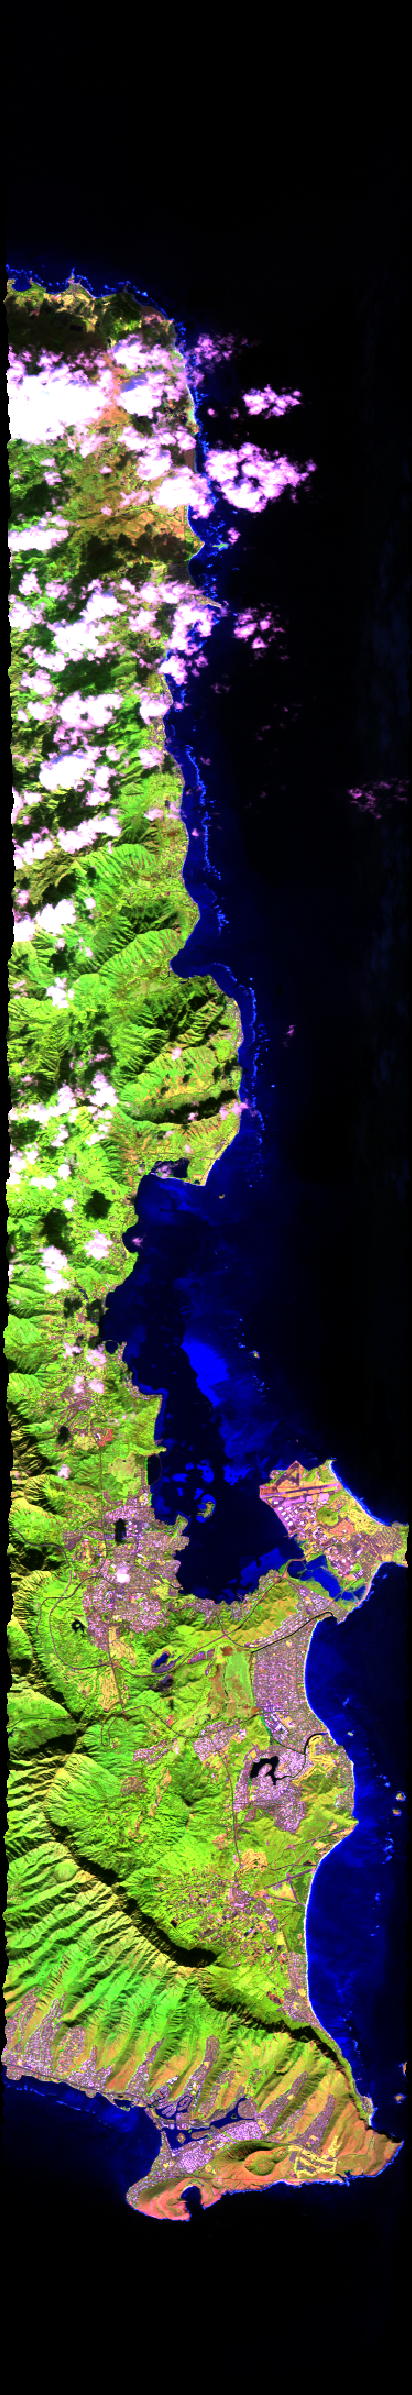

In [28]:
png = get_quicklook('badb6349-f3ae-4152-9f00-1cd3943151e9')
IPython.display.Image(png)

In [297]:
cwls

[]